In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
# import pygwalker as pyg
import re

# وارد کردن داده‌ها
file_names = [
    'U98.xlsx', 'U99.xlsx', 'U1400.xlsx', 'U1401.xlsx', 'R98.xlsx', 'R99.xlsx', 'R1400.xlsx', 'R1401.xlsx',
]

# لیست برای ذخیره داده‌های خوانده شده
M98_1401 = []

# خواندن فایل‌ها و افزودن ستون‌های جدید
for file_name in file_names:
    xls = pd.ExcelFile(file_name)
    temp = re.findall(r'\d+', file_name)
    print(temp)
    for sheet_name in xls.sheet_names:
        p = xls.parse(sheet_name)
        p['dataYear'] = np.full(len(p), temp)
        p['R/U'] = 'U' if file_name.startswith('U') else 'R'
        M98_1401.append(p)

# ادغام داده‌ها
temp = M98_1401.copy()
M98_1401 = []
for i in range(1, 22):
    i = i - 1
    M98_1401.append(pd.concat((temp[i], temp[i+21], temp[i+2*21], temp[i+3*21], temp[i+4*21], temp[i+5*21], temp[i+6*21], temp[i+7*21]), axis=0))

# پیش‌پردازش
## اطلاعات خانواده
info_Family = M98_1401[0][['Address', 'Fasl', 'province','khanevartype', 'dataYear', 'R/U']]

## اطلاعات اعضا
info_Member = M98_1401[1].copy()

## هزینه‌ها
## هزینه‌های خوراک و نوشیدنی
cost1 = pd.concat((M98_1401[3], M98_1401[4]), axis=0)

### هزینه‌های اجاره
cost2 = M98_1401[6]

### سایر هزینه‌ها
M98_1401[15]['value'] = pd.to_numeric(M98_1401[15]['value'], errors='coerce')
M98_1401[16]['value'] = pd.to_numeric(M98_1401[16]['value'], errors='coerce')
cost3 = pd.concat((M98_1401[5], M98_1401[7], M98_1401[8], M98_1401[9], M98_1401[10], M98_1401[11], M98_1401[12], M98_1401[13], M98_1401[14], M98_1401[15], M98_1401[16]), axis=0).reset_index(drop=True)

### ادغام همه هزینه‌ها
cost = pd.concat((cost1, cost2, cost3), axis=0)

# پاکسازی داده‌ها
cost = cost.fillna(0)

## ایجاد ستون دسته‌بندی
cost['catagory'] = cost.code.astype(str).str[:1]
cost['len'] = len(cost.code.astype(str))
cost[cost.len == 6]['catagory'] == '11'
## پاک‌سازی ستون‌های 'gram' و 'kilogram'
cost['gram'] = pd.to_numeric(cost['gram'], errors='coerce')
cost['kilogram'] = pd.to_numeric(cost['kilogram'], errors='coerce')

# ایجاد ستون 'len' که طول هر کد را ذخیره می‌کند
cost['len'] = cost.code.astype(str).apply(len)

# به‌روزرسانی ستون 'catagory' برای رکوردهایی که شرایط خاص را دارند
cost.loc[(cost.code.astype(str).apply(len) == 6) & (cost.code.astype(str).str[:4] == '1111'), 'catagory'] = '11'

## محاسبه ستون 'Kilogram'
cost['Kilogram'] = cost['gram'] / 1000 + cost['kilogram']

## گروه‌بندی داده‌ها بر اساس آدرس، سال داده، دسته‌بندی و نوع (شهری/روستایی)
grouped_cost = cost.groupby(['Address', 'dataYear', 'catagory', 'R/U'])[['value', 'Kilogram']].sum().reset_index()

# استفاده از np.isin برای ایجاد ماسک بولی
mask = np.isin(grouped_cost['catagory'], ['1', '3', '4', '6', '7', '11'])

# فیلتر کردن داده‌ها بر اساس ماسک بولی
filtered_cost = grouped_cost[mask]

# ادغام داده‌های درآمد
income = M98_1401[17].merge(M98_1401[18].iloc[:, 0:16], on=['Address', 'member'], how='inner') \
    .merge(M98_1401[19].iloc[:, 0:8].merge(M98_1401[20].iloc[:, 0:5], on=['Address', 'member'], how='inner'), on=['Address', 'member'], how='inner').drop('DYCOL00', axis=1)

# پاک‌سازی داده‌های درآمد
cleaned_income = income.copy()
cleaned_income['employed_w'] = cleaned_income['employed_w'].replace(' ', np.nan).fillna(0).astype('float64')
cleaned_income['employed_s'] = cleaned_income['employed_s'].replace(' ', np.nan).fillna(0).astype('float64')
cleaned_income['status_w'] = pd.to_numeric(cleaned_income['status_w'], errors='coerce').fillna(0)
cleaned_income['status_s'] = pd.to_numeric(cleaned_income['status_s'], errors='coerce').fillna(0)
cleaned_income['hours_w'] = pd.to_numeric(cleaned_income['hours_w'], errors='coerce').fillna(0)
cleaned_income['hours_s'] = pd.to_numeric(cleaned_income['hours_s'], errors='coerce').fillna(0)
cleaned_income['days_w'] = pd.to_numeric(cleaned_income['days_w'], errors='coerce').fillna(0)
cleaned_income['days_s'] = pd.to_numeric(cleaned_income['days_s'], errors='coerce').fillna(0)
cleaned_income['income_s_y'] = pd.to_numeric(cleaned_income['income_s_y'], errors='coerce').fillna(0)

# ایجاد ستون‌های جدید بر اساس محاسبات
cleaned_income['Employed'] = cleaned_income['employed_w'] + cleaned_income['employed_s']
cleaned_income['ISCO'] = cleaned_income['ISCO_w'] + cleaned_income['ISCO_s']
cleaned_income['ISIC'] = cleaned_income['ISIC_w'] + cleaned_income['ISIC_s']
cleaned_income['Status'] = cleaned_income['status_w'] + cleaned_income['status_s']
cleaned_income['Hours'] = cleaned_income['hours_w'] + cleaned_income['hours_s']
cleaned_income['Days'] = cleaned_income['days_w'] + cleaned_income['days_s']

# انتخاب ستون‌های نهایی برای تحلیل درآمد
final_income = cleaned_income[[
    'Address','Employed', 'ISCO_w', 'ISIC_w', 'Status', 'Hours', 'Days', 'ISCO_s', 'ISIC_s', 'netincome_w_m', 'netincome_w_y', 'agriculture', 'sale', 'income_s_y',
    'income_pension', 'income_rent', 'income_interest', 'income_aid', 'income_resale', 'income_transfer', 'subsidy_month', 'subsidy', 'Fasl', 'dataYear', 'R/U'
]].fillna(0)
info_Family.to_csv('info_Family.csv')
info_Member.to_csv('info_Member.csv')
filtered_cost.to_csv('filtered_cost.csv')
final_income.to_csv('final_income.csv')
# تابع محاسبه IQR و حذف نقاط دورافتاده
def Iqr_F(T):
    d1 = T.quantile(0.25)
    d3 = T.quantile(0.75)
    iqr = d3 - d1
    low_bound = d1 - 3 * iqr
    up_bound = d3 + 3 * iqr
    outliers = T[(T < low_bound) | (T > up_bound)].index
    T_copy = T.copy()
    # T_copy[outliers] = np.nan
    T_copy = T.clip(lower=low_bound, upper=up_bound)
    return pd.DataFrame(T_copy)


In [ ]:
info_Family = info_Family.read_csv('info_Family.csv')
info_Member = info_Member.read_csv('info_Member.csv')
filtered_cost = filtered_cost.read_csv('filtered_cost.csv')
final_income = final_income.read_csv('final_income.csv')
# # ایجاد ستون 'len' که طول هر کد را ذخیره می‌کند
# cost['len'] = cost.code.astype(str).apply(len)
# # به‌روزرسانی ستون 'catagory' برای رکوردهایی که شرایط خاص را دارند
# cost.loc[(cost.code.astype(str).apply(len) == 6) & (cost.code.astype(str).str[:4] == '1111'), 'catagory'] = '11'
# ## محاسبه ستون 'Kilogram'
# cost['Kilogram'] = cost['gram'] / 1000 + cost['kilogram']
# ## گروه‌بندی داده‌ها بر اساس آدرس، سال داده، دسته‌بندی و نوع (شهری/روستایی)
# grouped_cost = cost.groupby(['Address', 'dataYear', 'catagory', 'R/U'])[['value', 'Kilogram']].sum().reset_index()
# # استفاده از np.isin برای ایجاد ماسک بولی
# mask = np.isin(grouped_cost['catagory'], ['1', '3', '4', '6', '7', '11'])
# # فیلتر کردن داده‌ها بر اساس ماسک بولی
# filtered_cost = grouped_cost[mask]

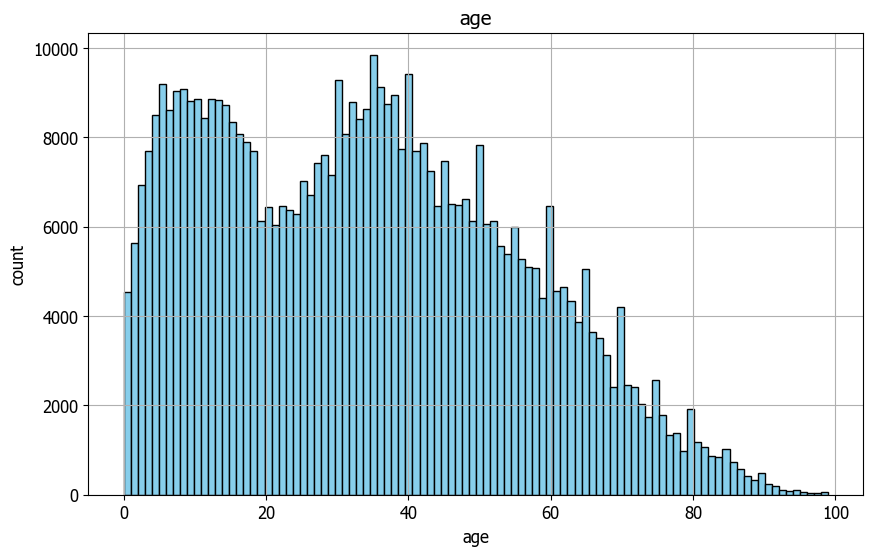

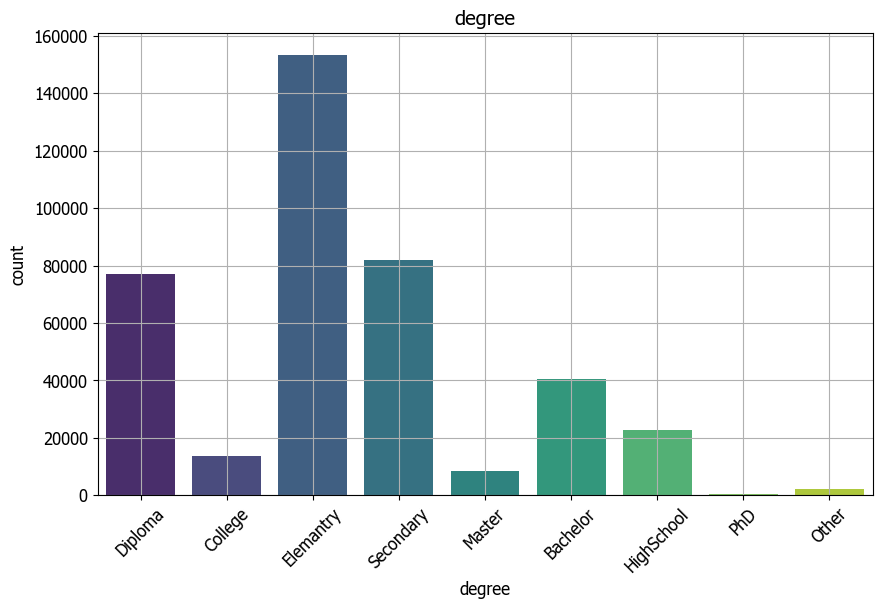

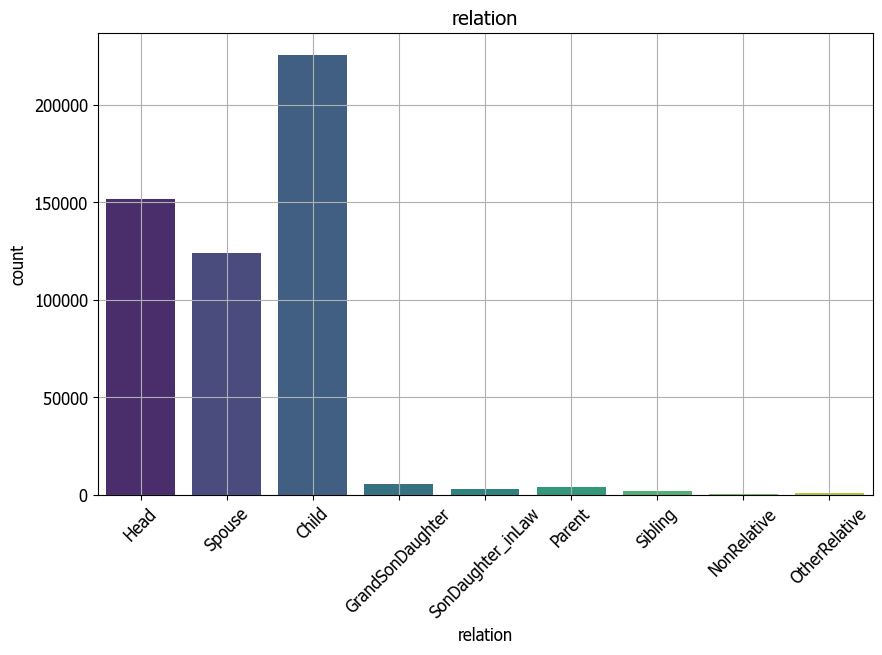

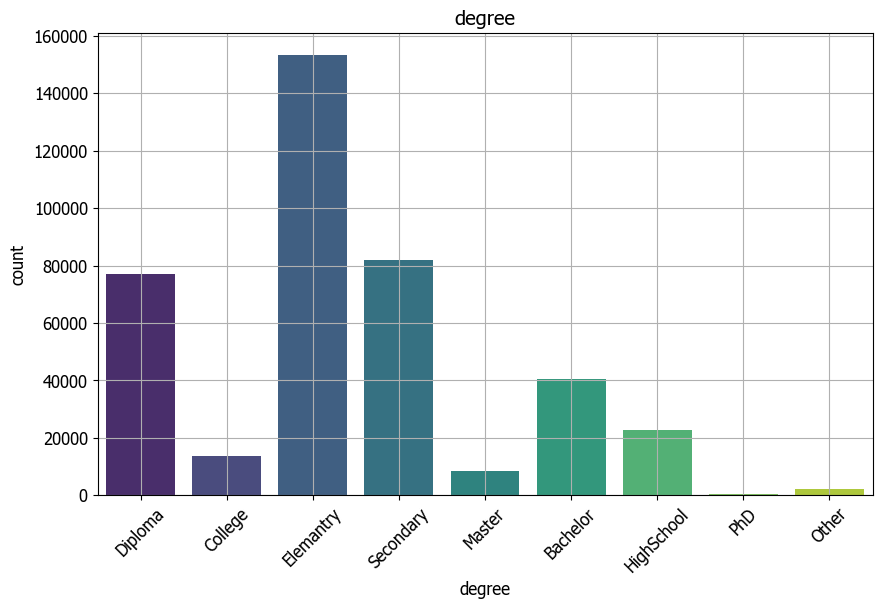

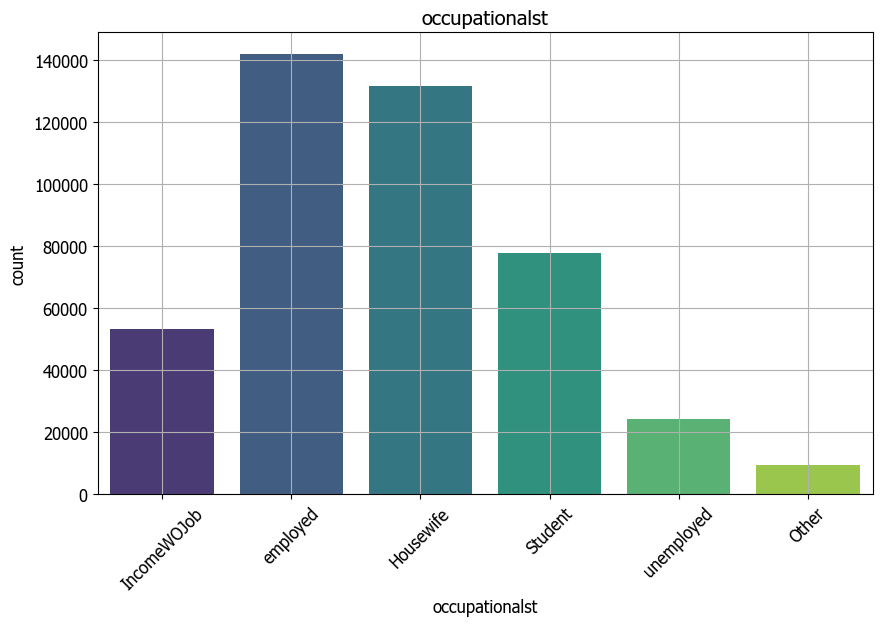

C:\Users\DELL\AppData\Local\Temp\ipykernel_1336\4060747489.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cost.dataYear = pd.Categorical(filtered_cost['dataYear'],categories=['98','99','1400','1401'],ordered=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_1336\4060747489.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend_cost = filtered_cost[filtered_cost['catagory'].isin(['11'])].groupby(['dataYear', 'catagory'])['value'].sum().unstack()


catagory            11
dataYear              
98        8.622945e+09
99        6.300790e+09
1400      1.379598e+10
1401      2.435047e+10


c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


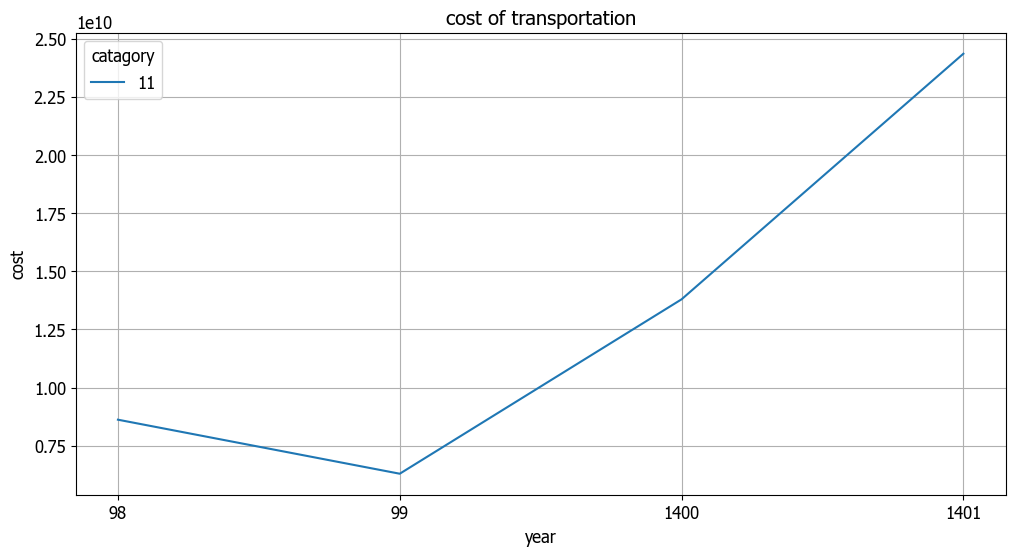

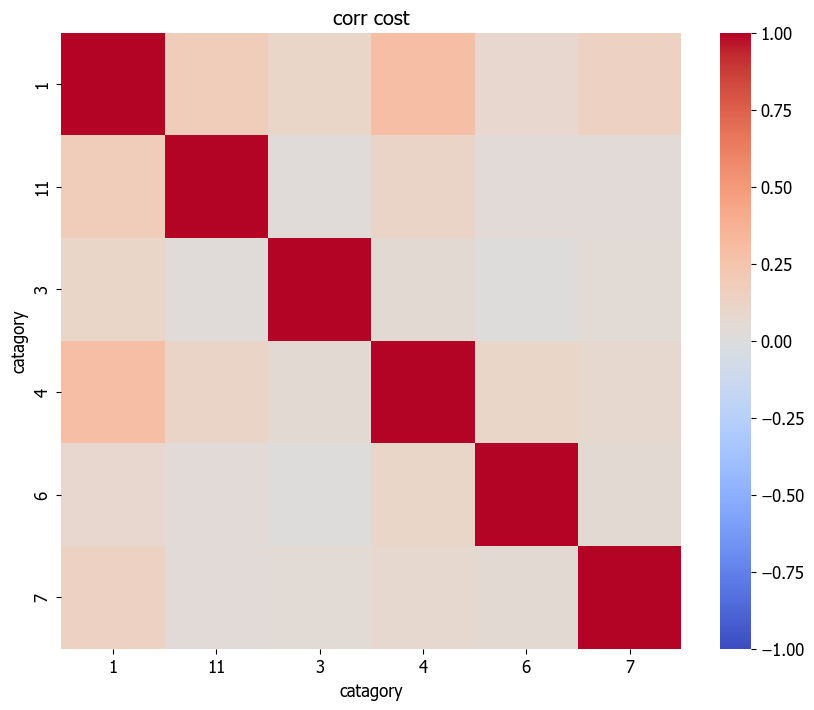

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# تنظیمات فونت فارسی برای Matplotlib
plt.rcParams['font.family'] = 'Tahoma'  # نام فونت مورد نظر را وارد کنید
plt.rcParams['font.size'] = 12
# آمار توصیفی
# توزیع سن
plt.figure(figsize=(10, 6))
plt.hist(info_Member['age'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('age')
plt.ylabel('count')
plt.title('age')
plt.grid(True)
plt.show()

# توزیع میزان تحصیلات
plt.figure(figsize=(10, 6))
sns.countplot(data=info_Member, x='degree', palette='viridis')
plt.xlabel('degree')
plt.ylabel('count')
plt.title('degree')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# توزیع بستگی با سرپرست
plt.figure(figsize=(10, 6))
sns.countplot(data=info_Member, x='relation', palette='viridis')
plt.xlabel('relation')
plt.ylabel('count')
plt.title('relation')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# توزیع پایه یا مدرک
plt.figure(figsize=(10, 6))
sns.countplot(data=info_Member, x='degree', palette='viridis')
plt.xlabel('degree')
plt.ylabel('count')
plt.title('degree')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# توزیع وضع فعالیت
plt.figure(figsize=(10, 6))
sns.countplot(data=info_Member, x='occupationalst', palette='viridis')
plt.xlabel('occupationalst')
plt.ylabel('count')
plt.title('occupationalst')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# ترند هزینه خانوار برای هر سال برای غذاهای آماده، هتل و رستوران
# filtered_cost.dataYear = pd.to_numeric(filtered_cost.dataYear, errors='coerce')
# filtered_cost = filtered_cost.sort_values(by='dataYear',ascending=False)
filtered_cost.dataYear = pd.Categorical(filtered_cost['dataYear'],categories=['98','99','1400','1401'],ordered=True)

trend_cost = filtered_cost[filtered_cost['catagory'].isin(['11'])].groupby(['dataYear', 'catagory'])['value'].sum().unstack()
# trend_cost.catagory[trend_cost.catagory == '98'] = '1398'
trend_cost = trend_cost.sort_values(by='dataYear',ascending=True)
print(trend_cost)
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_cost)
plt.xlabel('year')
plt.ylabel('cost')
plt.title('cost of transportation')
plt.grid(True)
plt.show()

# ماتریس هم‌بستگی برای هزینه‌های مختلف
selected_costs = grouped_cost[grouped_cost['catagory'].isin(['1', '3', '4', '6', '7', '11'])]
pivot_costs = selected_costs.pivot_table(index='Address', columns='catagory', values='value', aggfunc='sum').fillna(0)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_costs.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('corr cost')
plt.show()

In [78]:
from scipy.stats import ttest_ind
final_income_p = final_income.merge(info_Family[['Address','province']],on='Address',how='inner')#.index#['catagory']#['datayear']
# فیلتر داده‌ها برای استان چهارمحال و بختیاری
province_data = final_income_p[final_income_p['province'] == 'CharmahalBakhtiari']

# درآمد خانوارهای شهری و روستایی
urban_income = province_data[province_data['R/U'] == 'U']['netincome_w_y']
rural_income = province_data[province_data['R/U'] == 'R']['netincome_w_y']

# آزمون t-test مستقل
t_stat, p_value = ttest_ind(urban_income, rural_income, equal_var=False)

print(f"t-statistic: {t_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("درآمد خانوارهای شهری و روستایی در استان چهارمحال و بختیاری با هم برابر نیست.")
else:
    print("درآمد خانوارهای شهری و روستایی در استان چهارمحال و بختیاری با هم برابر است.")


t-statistic: 12.396131576947766, p-value: 6.229384354625738e-35
درآمد خانوارهای شهری و روستایی در استان چهارمحال و بختیاری با هم برابر نیست.


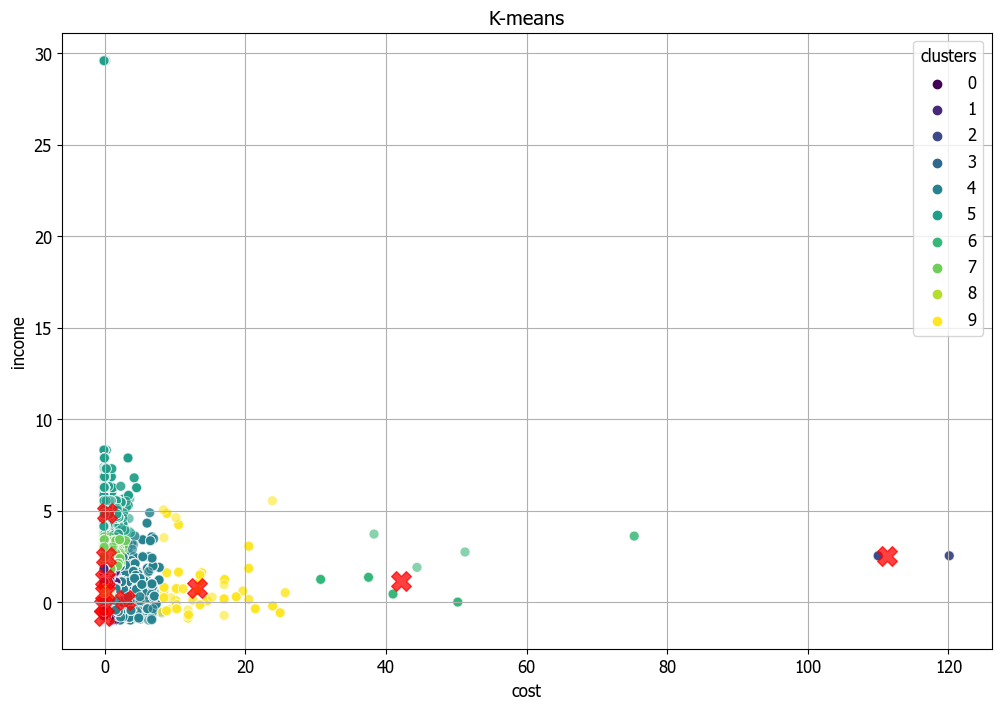

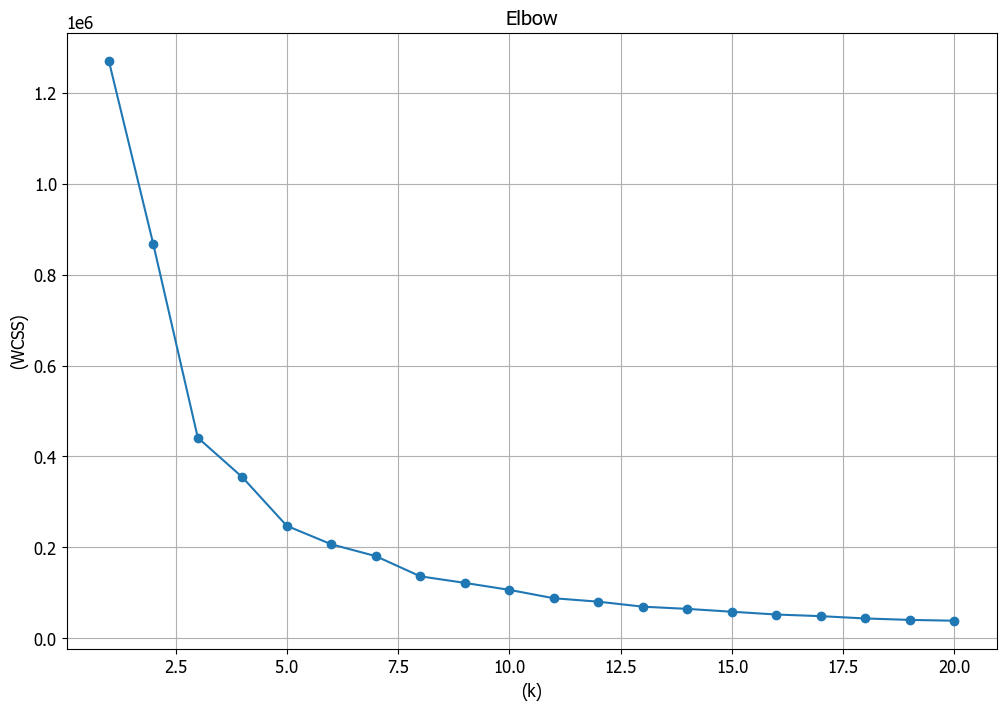

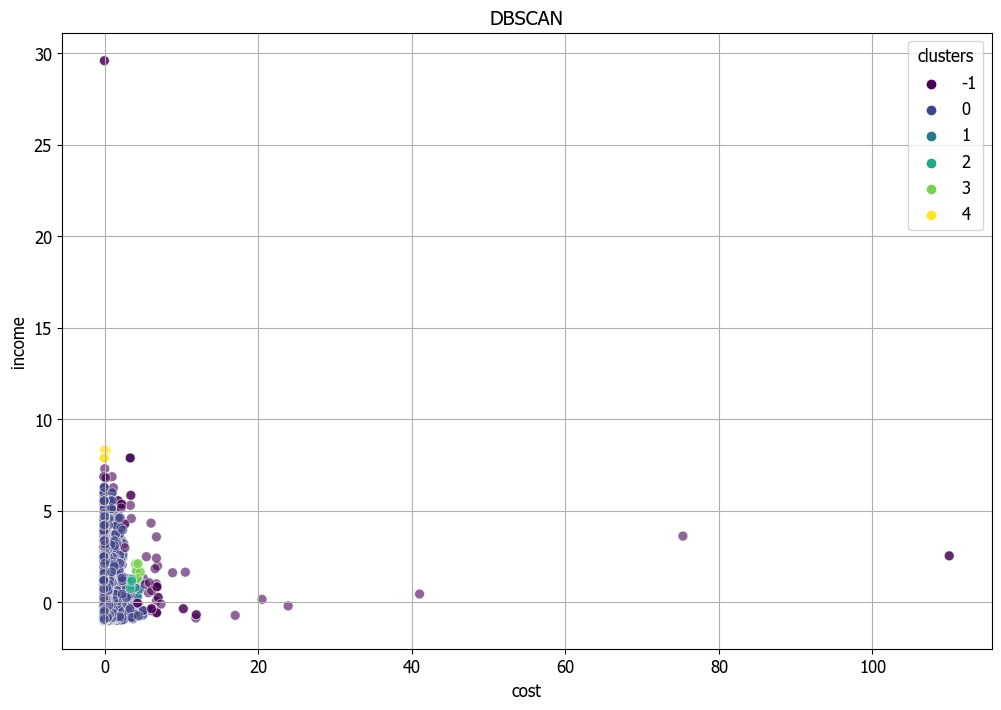

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
# فرض کنید که 'filtered_cost' و 'final_income' داده‌های هزینه و درآمد را شامل می‌شوند.

# ادغام داده‌های هزینه و درآمد بر اساس 'Address' و 'dataYear'
merged_data = filtered_cost.merge(final_income, on=['Address', 'dataYear'], how='inner')

# انتخاب ستون‌های مورد نیاز
data = merged_data[['value', 'netincome_w_y']]

# استانداردسازی داده‌ها
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# اجرای الگوریتم K-means با 10 خوشه
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(scaled_data)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# اضافه کردن برچسب خوشه‌ها به داده‌ها
merged_data['cluster'] = labels

# رسم اسکتر پلات با مراکز خوشه‌ها
plt.figure(figsize=(12, 8))
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=labels, palette='viridis', legend='full', s=50, alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')

# تنظیمات نمودار
plt.xlabel('cost')
plt.ylabel('income')
plt.title('K-means')
plt.legend(title='clusters')
plt.grid(True)
plt.show()


wcss = []

for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# رسم نمودار WCSS برای مقادیر مختلف k
plt.figure(figsize=(12, 8))
plt.plot(range(1, 21), wcss, marker='o')
plt.xlabel('(k)')
plt.ylabel('(WCSS)')
plt.title('Elbow')
plt.grid(True)
plt.show()
# کاهش اندازه داده‌ها به 5% داده‌های اصلی
sampled_data = scaled_data[np.random.choice(scaled_data.shape[0], size=int(scaled_data.shape[0] * 0.05), replace=False)]

dbscan = DBSCAN(eps=0.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(sampled_data)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=sampled_data[:, 0], y=sampled_data[:, 1], hue=labels_dbscan, palette='viridis', legend='full', s=50, alpha=0.6)
plt.xlabel('cost')
plt.ylabel('income')
plt.title('DBSCAN')
plt.legend(title='clusters')
plt.grid(True)
plt.show()

